In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("spam_dataset.csv")
df = df.dropna(subset=['text']).reset_index(drop=True)

In [3]:
def train_split(df, size):
  np.random.seed(4)
  indices = np.random.permutation(len(df))
  # print(indices)
  split = int(len(df) * size)
  train = indices[:split]
  test = indices[split:]
  train_df = df.iloc[train]
  test_df = df.iloc[test]
  # print(train_df.head(20))
  # print(test_df.head(20))
  x_train = train_df.drop('label', axis=1)
  y_train = train_df['label'].values
  x_test = test_df.drop('label', axis=1)
  y_test = test_df['label'].values
  return x_train, y_train, x_test, y_test

In [4]:
x_train, y_train, x_test, y_test = train_split(df, 0.8)
print(f"x shape: {x_train.shape}")
print(f"y shape: {y_train.shape}")

x shape: (26692, 8)
y shape: (26692,)


In [5]:
def build_vocabulary(x_train, vocab_size=1000):
    all_words = " ".join(x_train['text']).split()
    word_counts = pd.Series(all_words).value_counts()
    return word_counts.head(vocab_size).index.tolist()
vocab = build_vocabulary(x_train, vocab_size=1000)

In [6]:
def vectorize_text(text, vocab):
  matrix = np.zeros((len(text), len(vocab)))
  for i, text in enumerate(text):
    words = str(text).split()
    for word in words:
      if word in vocab:
        col_idx = vocab.index(word)
        matrix[i, col_idx] += 1
  return matrix

In [7]:
train_count = vectorize_text(x_train['text'], vocab)
# print(train_count)

In [8]:
p_spam = np.mean(y_train)
p_ham = 1 - p_spam

In [9]:
eng_cols = ['digit_ratio', 'has_url', 'lexical_diversity', 'avg_word_len']
x_spam = train_count[y_train == 1]
x_ham = train_count[y_train == 0]

word_counts_spam = np.sum(x_spam, axis=0) + 1
word_counts_ham = np.sum(x_ham, axis=0) + 1

prob_word_spam = word_counts_spam / (np.sum(word_counts_spam))
prob_word_ham = word_counts_ham / (np.sum(word_counts_ham))

# print(prob_word_ham, prob_word_spam)

log_prob_spam = np.log(prob_word_spam)
log_prob_ham = np.log(prob_word_ham)

log_prior_spam = np.log(p_spam)
log_prior_ham = np.log(p_ham)

print(log_prior_ham, log_prior_spam)
# print(log_prob_ham, log_prob_spam)

-0.5958363604280139 -0.8009583713796269


In [10]:
spam_stats = {
    'mean': x_train[y_train == 1][eng_cols].mean(),
    'var': x_train[y_train == 1][eng_cols].var() + 0.01 # Add tiny epsilon to avoid div by zero
}

ham_stats = {
    'mean': x_train[y_train == 0][eng_cols].mean(),
    'var': x_train[y_train == 0][eng_cols].var() + 0.01
}

def get_gaussian_log_prob(x, mean, var):
    coeff = -0.5 * np.log(2 * np.pi * var)
    exponent = -0.5 * ((x - mean)**2 / var)
    return coeff + exponent

In [11]:
def predict(X_df, vocab, log_prior_spam, log_prior_ham, log_prob_spam, log_prob_ham, spam_stats, ham_stats):
    X_counts = vectorize_text(X_df['text'], vocab)
    text_score_spam = log_prior_spam + (X_counts @ log_prob_spam)
    text_score_ham = log_prior_ham + (X_counts @ log_prob_ham)
    eng_score_spam = 0
    eng_score_ham = 0
    weight = 0.1
    for col in eng_cols:
        eng_score_spam += get_gaussian_log_prob(X_df[col], spam_stats['mean'][col], spam_stats['var'][col])
        eng_score_ham += get_gaussian_log_prob(X_df[col], ham_stats['mean'][col], ham_stats['var'][col])
    final_spam = text_score_spam + (eng_score_spam * weight)
    final_ham = text_score_ham + (eng_score_ham * weight)
    return (final_spam > final_ham).astype(int)

y_pred = predict(x_test, vocab, log_prior_spam, log_prior_ham,
                               log_prob_spam, log_prob_ham, spam_stats, ham_stats)

print(f"Accuracy: {np.mean(y_pred == y_test):.2%}")

Accuracy: 95.55%


Precision: 0.9436
Recall: 0.9605
F1 Score: 0.9520


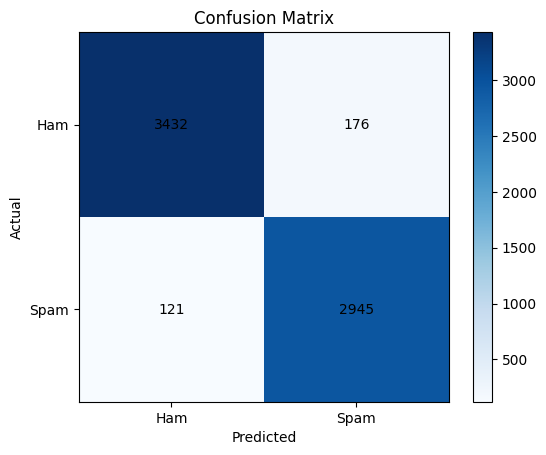

In [12]:
tn = np.sum((y_test == 0) & (y_pred == 0))
fp = np.sum((y_test == 0) & (y_pred == 1))
fn = np.sum((y_test == 1) & (y_pred == 0))
tp = np.sum((y_test == 1) & (y_pred == 1))
cm = np.array([[tn, fp], [fn, tp]])

# Plotting
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Ham', 'Spam'])
plt.yticks(tick_marks, ['Ham', 'Spam'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")

plt.ylabel('Actual')
plt.xlabel('Predicted')

# Metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
import pickle
model_data = {
    "vocab": vocab,
    "log_prob_spam": log_prob_spam,
    "log_prob_ham": log_prob_ham,
    "log_prior_spam": log_prior_spam,
    "log_prior_ham": log_prior_ham,
    "spam_stats": spam_stats,
    "ham_stats": ham_stats,
    "eng_cols": eng_cols
}

with open('spam_detection.pkl', 'wb') as f:
    pickle.dump(model_data, f)


In [22]:
from collections import Counter
def test(message, m):
    chars = len(message)
    words_list = message.split()
    words_count = len(words_list) if len(words_list) > 0 else 1
    feat = {
        'digit_ratio': sum(c.isdigit() for c in message) / chars if chars > 0 else 0,
        'has_url': 1 if any(x in message.lower() for x in ['http', 'www', '.com']) else 0,
        'lexical_diversity': len(set(words_list)) / words_count,
        'avg_word_len': chars / words_count
    }
    counts = Counter(words_list)
    vec = np.array([counts[word] for word in m["vocab"]])

    t_score_spam = m["log_prior_spam"] + (vec @ m["log_prob_spam"])
    t_score_ham = m["log_prior_ham"] + (vec @ m["log_prob_ham"])

    e_score_spam = sum(get_gaussian_log_prob(feat[col], m['spam_stats']['mean'][col], m['spam_stats']['var'][col]) for col in m["eng_cols"])
    e_score_ham = sum(get_gaussian_log_prob(feat[col], m['ham_stats']['mean'][col], m['ham_stats']['var'][col]) for col in m["eng_cols"])
    is_spam = (t_score_spam + e_score_spam) > (t_score_ham + e_score_ham)
    return ("SPAM", 1) if is_spam else ("HAM", 0)
    # return "SPAM" if is_spam else "HAM"

In [23]:
import csv
with open("spam_test.csv", "r", newline="") as f:
    rows = csv.reader(f)
    next(rows)
    messages = []
    for row in rows:
        messages.append((row[2], row[3]))


In [25]:
with open("model.pkl", "rb") as f:
  m = pickle.load(f)
spam = ham = correct = 0
for msg, status in messages:
  res = test(msg, m)[1]
  if(res == 1):
    spam += 1
  elif(res == 0):
    ham += 1
  if(res == int(status)):
    correct += 1

print("Accuracy: ", correct/len(messages)*100)

Accuracy:  94.02436666022047
